# EIGSEP Sims

Aaron Parsons

In [1]:
import numpy as np
import matplotlib.pylab as plt
import aipy
import os
import tqdm
import healpy
import croissant as cro
from astropy.time import Time, TimezoneInfo
import astropy.units as u
from scipy.constants import c as C, k as k_B
from dateutil.parser import parse  
Jy_mks = 1e-26

%matplotlib widget

In [2]:
npz = np.load('eigsep_vivaldi.npz')
bm = npz['bm'].astype('float32')
freqs = npz['freqs']

npz = np.load('horizon_model.npz')
nside_horizon = npz['nside']
horizon_r = npz['r']
sky_mask = np.where(np.isnan(horizon_r), 1, 0)

nside_beam = healpy.npix2nside(bm.shape[1])
bm_norm = bm[:, healpy.vec2pix(nside_beam, 0, 0, 1)]
bm /= bm_norm[:, None]
dOmega = 4 * np.pi / bm.shape[1]
Omega_beam = dOmega * np.sum(bm, axis=1)
K2Jy = 2 * k_B * (freqs / C)**2 * Omega_beam  / Jy_mks
Jy2K = 1 / K2Jy

class Beam(aipy.healpix.HealpixMap):
    def __getitem__(self, crd):
        """Access data on a sphere via hpm[crd].
        crd = either 1d array of pixel indices, (th,phi), or (x,y,z), where
        th,phi,x,y,z are numpy arrays of coordinates."""
        if type(crd) is tuple:
            crd = [aipy.healpix.mk_arr(c, dtype=np.double) for c in crd]
            if self._use_interpol:
                px, wgts = self.crd2px(*crd, **{'interpolate':1})
                return np.sum(self.map[px] * wgts.reshape(wgts.shape + (1,) * (self.map.ndim - 1)), axis=1)
            else:
                px = self.crd2px(*crd)
        else:
            px = aipy.healpix.mk_arr(crd, dtype=np.int64)
        return self.map[px]
    def set_map(self, data, scheme="RING"):
        """Assign data to HealpixMap.map.  Infers Nside from # of pixels via
        Npix = 12 * Nside**2."""
        try:
            nside = self.npix2nside(data.shape[0])
        except(AssertionError,ValueError):
            raise ValueError("First axis of data must have 12*N**2.")
        self.set_nside_scheme(nside, scheme)
        self.map = data
        
beam_hpx = Beam(nside_beam, interp=True)
Tgnd = np.mean(300 * bm * (1 - sky_mask[None, :]), axis=1)
bm *= sky_mask[None, :]
beam_hpx.set_map((bm * sky_mask[None, :]).T)

In [3]:
_t_start = parse('2024-10-17T12:00:00-6:00')  # local time at Marjum Pass
_t_end   = parse('2024-10-18T12:00:00-6:00')  # local time at Marjum Pass
t_start = Time(_t_start)
t_end = Time(_t_end)
latitude = 39.247699
longitude = -113.402660
altitude = 1800 # m
loc = (longitude, latitude)
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
ch = 150
beam_alm = np.array([healpy.map2alm(bm[ch]) for ch in range(freqs.size)])

In [4]:
#plt.figure()
#plt.plot(freqs / 1e6, Omega_beam)

In [5]:
from pygdsm import GlobalSkyModel16 as GSM16
gsm = GSM16(freq_unit='Hz', data_unit='TRJ', resolution='lo', include_cmb=True)
gsm_hpx = gsm.generate(freqs)
gsm_nside = healpy.npix2nside(gsm_hpx.shape[1])
gsm_gvec = healpy.pix2vec(gsm_nside, np.arange(gsm_hpx.shape[1]))

In [6]:
if not os.path.exists('eigsep_tgsm_sim.npz'):
    ga2eq_m= aipy.coord.convert_m('ga', 'eq')
    Tgsm = []
    for jd in times.jd:
        loc.set_jultime(jd)
        ga2top_m = np.dot(loc.eq2top_m, ga2eq_m)
        tx, ty, tz = np.dot(ga2top_m, gsm_gvec)
        bm_resp = beam_hpx[tx, ty, tz].T
        Tgsm.append(np.mean(bm_resp * gsm_hpx, axis=1))
    Tgsm = np.array(Tgsm)
    np.savez('eigsep_tgsm_sim.npz', freqs=freqs, times=np.array(times.jd), Tgsm=Tgsm, latitude=latitude, longitude=longitude)
else:
    npz = np.load('eigsep_tgsm_sim.npz')
    Tgsm = npz['Tgsm']

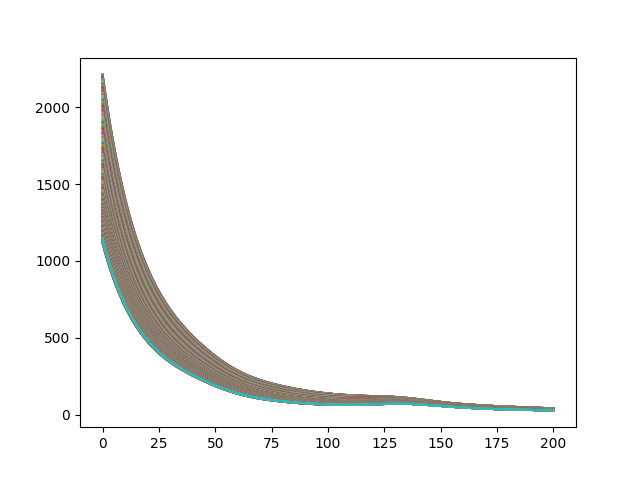

In [16]:
fig, axes = plt.subplots()
_ = axes.plot((Tgsm + Tgnd[None, :]).T)

In [17]:
nside = 32
lmax = 64
beam = cro.Beam(beam_alm, frequencies=freqs, coord="T")
sky = cro.Sky.gsm(freqs / 1e6, lmax=lmax)
sky.frequencies *= 1e6  # get back from MHz to Hz
sim = cro.Simulator(beam, sky, world="earth", location=loc, times=times)

ValueError: "<ephem.Observer date='2024/10/18 18:00:00' epoch='2024/10/18 18:00:00' lon='-113:24:09.6' lat='39:14:51.7' elevation=1799.9999999999998m horizon=0:00:00.0 temp=15.0C pressure=0.0mBar>" was passed into an EarthLocationAttribute, but it does not have "transform_to" method

In [9]:
#healpy.mollview(sim.beam.hp_map(nside, freqs[ch])[0], title=f"Beam at {freqs[ch]/1e6:.0f} MHz")
#healpy.mollview(sim.sky.hp_map(nside, freqs[ch])[0], title=f"Sky at {freqs[ch]/1e6:.0f} MHz")

In [10]:
srcs = ('Sun', 'Moon', 'cyg', 'cas', 'vir', 'crab')
cat = aipy.src.get_catalog(catalogs=['misc'])
aipy_beam = aipy.phs.Beam(freqs / 1e9)
ant = aipy.phs.Antenna(0, 0, 0, aipy_beam)
loc = aipy.amp.AntennaArray((np.deg2rad(latitude), np.deg2rad(longitude), altitude), [ant])
alts = {k: [] for k in srcs}
Tsrc = {k: [] for k in srcs}
for jd in times.jd:
    loc.set_jultime(jd)
    cat.compute(loc)
    for k in alts.keys():
        alts[k].append(float(cat[k].alt))
        tx, ty, tz = cat[k].get_crds('top')
        Tsrc[k].append(beam_hpx[tx, ty, tz] * cat[k].get_jys() * Jy2K)
alts = {k: np.array(v) for k, v in alts.items()}
Tsrc = {k: np.concatenate(v, axis=0) for k, v in Tsrc.items()}
plot_times = (times.unix - times.unix[0]) / 3600

In [11]:
#plt.figure()
#plt.imshow(Tsrc['cyg'], aspect='equal', interpolation='nearest', cmap='plasma')

(300, 201) (201,) (300,)


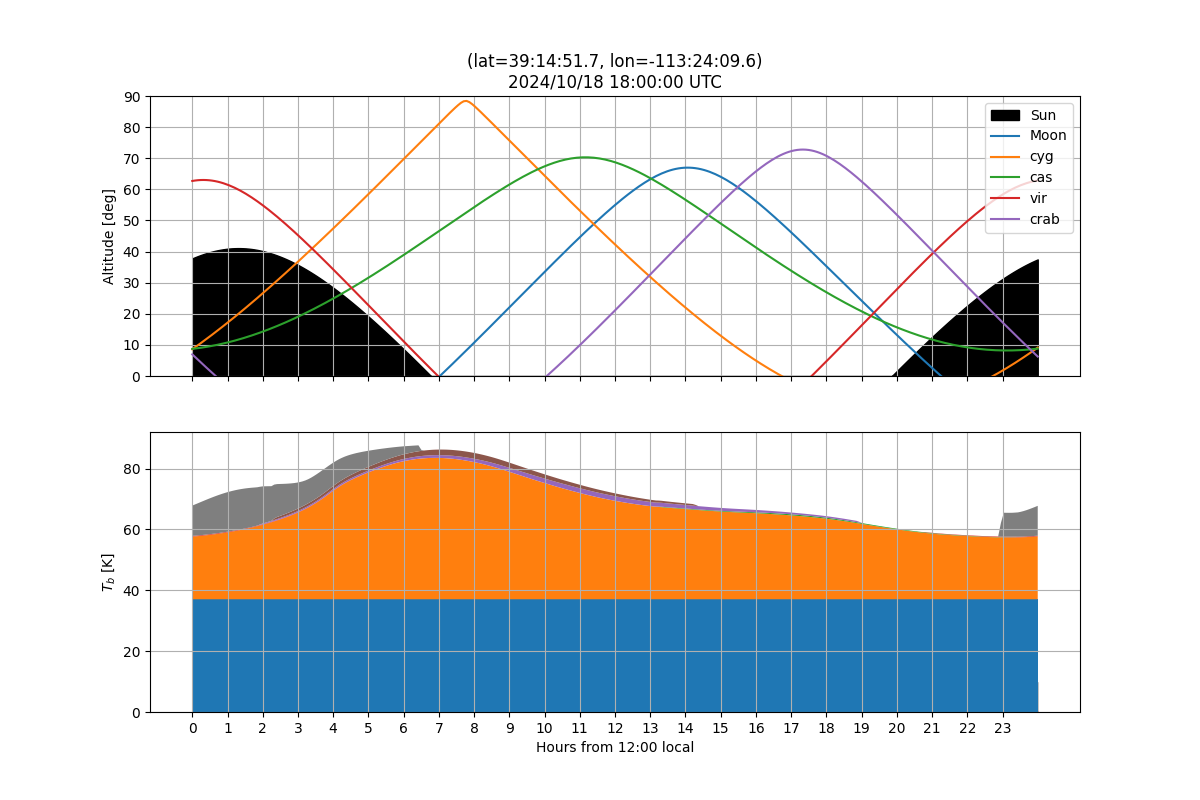

In [12]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
ch = 150
for k, v in alts.items():
    if k == 'Sun':
        color = 'k'
        axes[0].fill_between(plot_times, np.rad2deg(alts['Sun']), label='Sun', color=color)
    else:
        line, = axes[0].plot(plot_times, np.rad2deg(v), label=k)
        color = line.get_color()
    axes[1].fill_between(plot_times, Tsrc[k][:, ch], label=k, alpha=0.2, color=color)
print(Tgsm.shape, Tgnd.shape, plot_times.shape)
axes[1].stackplot(plot_times, Tgnd[ch] * np.ones_like(plot_times), Tgsm[:, ch], *[Tsrc[k][:, ch] for k in srcs[::-1]])
#axes[1].fill_between(plot_times, Tgsm[:, 100] + Tgnd[100], label=f'Tsky @ {freqs[100]/1e6:3.0f}MHz / 10', alpha=0.2)
axes[1].set_xlabel('Hours from 12:00 local')
axes[0].set_ylabel('Altitude [deg]')
axes[1].set_ylabel('$T_b$ [K]')
axes[0].set_ylim(0, 90)
axes[1].set_xticks(np.arange(24))
axes[0].grid()
axes[1].grid()
axes[0].legend(loc='best')
_ = axes[0].set_title(f'(lat={loc.lat}, lon={loc.lon})\n{loc.epoch} UTC')

In [13]:
cyg = cat['cyg']
cyg.get_jys() * Jy2K
print(cyg.get_crds('top'))

[0.6816587  0.71427241 0.15860748]


In [14]:
sim.run(dpss=False)

NameError: name 'sim' is not defined

NameError: name 'sim' is not defined

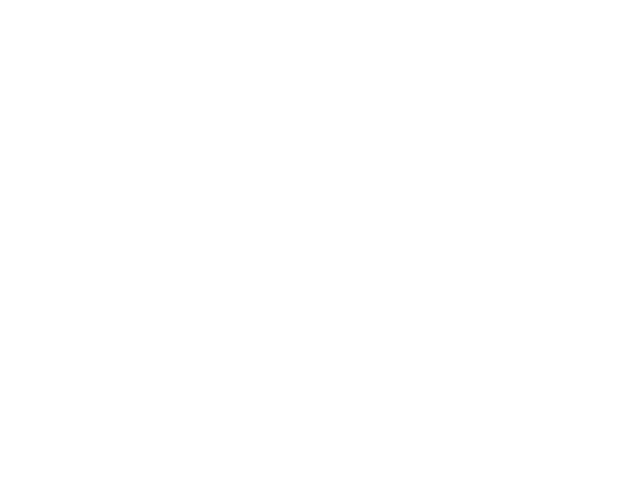

In [15]:
plt.figure()
plt.imshow(np.log10(sim.waterfall), aspect='auto', interpolation='nearest', cmap='plasma', vmax=3, vmin=2)

In [15]:
gsm = aipy.healpix.HealpixMap(nside=nside_scat)
th, phi = gsm.px2crd(np.arange(gsm.npix()), ncrd=2)
crd = np.array(gsm.px2crd(np.arange(gsm.npix())), dtype='float32')
az = -phi
az = np.where(az < 0, 2 * np.pi + az, az)
n_az = horizon_angles['1'].size
az_res = 2 * np.pi / n_az
b = np.around(az / az_res).astype(int) % n_az
sky_mask = (np.pi/2 - th >= horizon_angles['1'][b])

alm = aipy.healpix.Alm(2, 1)
alm[0, 0] = 1
alm[1, 0] = 0.1
alm[1, 1] = 0.1
gsm.from_alm(alm)

#T_sky_spec = 180 * (freqs.clip(1e6) / 180e6)**-2.5  # K, cold patch
T_sky_spec = 400 * (freqs.clip(1e6) / 180e6)**-2.5  # K
T_sky = T_sky_spec[None, :] * gsm.map[:, None]

T_hot_spec = 1e4 * (freqs.clip(1e6) / 150e6)**-1.9
hot_px = gsm.crd2px(0, 0.5**0.5, 0.5**0.5)
T_sky[hot_px] += T_hot_spec

T_sky = T_sky.astype('float32')

# every visible pixel on the sky takes a direct path to the antenna, and it also takes an indirect path to each terrain point
# visible to the antenna, where it can bounce and enter the antenna. The path length difference is the radial distance
# from the antenna to the terrain point, plus the baseline distance from the antenna to the terrain point projected toward
# each sky point.
# This baseline is np.dot(r * crd[terrain], crd[sky])
gnd_mask = ~np.isnan(r)
r_vec = np.array(healpy.pix2vec(nside_full, np.arange(r.size)), dtype='float32')
bls = r_vec[:, gnd_mask] * r[None, gnd_mask] # only terrain pixels
bl_proj = np.dot(crd[:, sky_mask].T, bls) + r[None, gnd_mask]
bl_proj = bl_proj.astype('float32')
df = np.float32(freqs[1] - freqs[2])

# average T over all sky reflections; could put a scattering beam in here
T_scat = np.empty((np.sum(gnd_mask), freqs.size))
for i in tqdm.tqdm(range(freqs.size)):
    T_scat[...,i] = np.mean(gamma[i] * T_sky[sky_mask, None, i] * np.cos(np.float32(2 * np.pi / C) * freqs[i] * bl_proj) * etu.pixel_delay_attenuation(bl_proj, df), axis=0)
    T_scat[...,i] *= etu.pixel_coherence_angle_attenuation(r[gnd_mask], freqs[i], nside=nside_full)

gsm_full = aipy.healpix.HealpixMap(nside=nside_full)
gsm_full.from_alm(alm)
gsm_full[0, np.sqrt(0.5), np.sqrt(0.5)] = 10
T_sky_full = T_sky_spec[None, :] * gsm_full.map[:, None]
T_gnd = 300 * np.ones_like(T_scat)
T_sky_full[gnd_mask] = T_scat + T_gnd

NameError: name 'nside_scat' is not defined

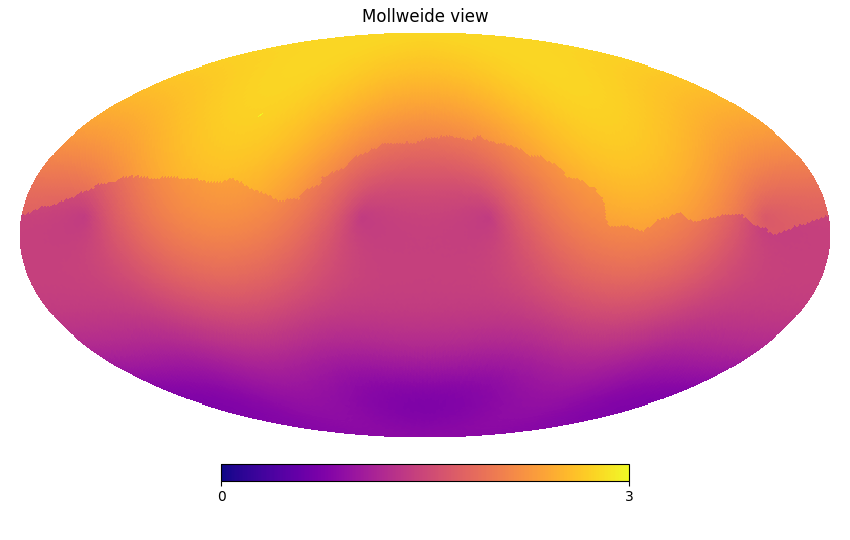

In [21]:
#healpy.mollview(h.map)
#from healpy.newvisufunc import projview, newprojplot
#projview(T_sky_full[:, 100], graticule=True, graticule_labels=False, projection_type="mollweide", cmap='plasma', min=0)
fq0 = 100e6
ch = np.argmin(np.abs(freqs - fq0))
healpy.mollview((np.log10(T_sky_full[:, ch] * bm[ch] / bm[ch].max())), cmap='plasma', min=0, max=3)

In [22]:
T_sky_mean = np.mean(T_sky[sky_mask], axis=0)
T_gnd_mean = np.mean(T_gnd, axis=0)
T_tot_mean = np.mean(T_sky_full, axis=0)
T_ant_mean = np.sum(T_sky_full * bm.T, axis=0) / np.sum(bm.T, axis=0)

In [3]:
# Make a cosmological signal
npz = np.load('models_21cm.npz')
mdl_freqs = npz['freqs'] * 1e9
mdl_T = npz['models'] * 1e-3
MODEL_INDEX = 120
mdl_interp = interp1d(mdl_freqs, mdl_T[MODEL_INDEX], fill_value=0, bounds_error=False)
T_21cm = mdl_interp(freqs)

NameError: name 'freqs' is not defined

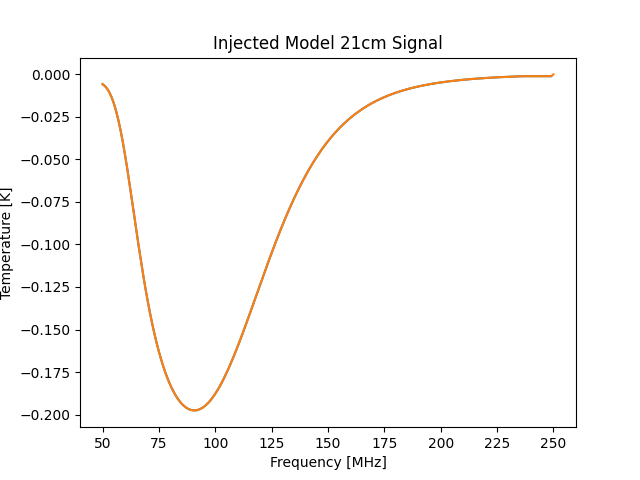

In [24]:
fig, axes = plt.subplots()
_ = axes.plot(mdl_freqs / 1e6, mdl_T[120])
_ = axes.plot(freqs / 1e6, T_21cm)
axes.set_title('Injected Model 21cm Signal')
axes.set_ylabel('Temperature [K]')
_ = axes.set_xlabel('Frequency [MHz]')